for more scope creep, using a 30 (or 60 or 90) day price plot estimate the most likley day that the stock will peak and use this as the sell date.


In [9]:
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BMonthEnd
import pickle
import joblib
from ta.momentum import RSIIndicator
from ta.trend import MACD
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix # Loading required libraries



### Todo:
when loading in All_features_and_prices_df.joblib and running dropna() check if some of the rows that are being droped only have it in teh prices but not in RSI and stuff that is used in the training

## Load data into df_by_ticker


Many columns will be created later and will contain columns such as:`'transaction_date', 'trade_date', 'ticker', 'company_name','owner_name', 'Title', 'transaction_type', 'last_price', 'Qty', 'shares_held', 'Owned', 'Value', 'eff_trans_date', 'Owned_norm', 'prev_prices', 'future_prices', 'SPY_1d_return',  'trade_date_epoch', 'eff_trans_date_epoch', '1mo_return', '3mo_return', '30d_volatility', 'rsi_14', 'macd', 'volume_zscore',  'price_vs_sma50', 'is_during_market_hours', 'day_of_week', 'filing_lad_days', 'title_rank', 'month_end_flag'],`

`'trade_date'`: The date the actual trade was made, tipically a few days prior to the transaction date.

`'transaction_date'`: The date the SEC filing was made.

`'eff_trans_date'`: Effective transaction date. For the purposes of this analysis we are considering before 9am (eg: on a Wednesday) as the previous day (Tuesday) all the way up until 9am the day prior (Tuesday). transaction made after 9am (on the wednesday) are considered to have been made on that day (Wednesday). This is because the information will not be acted upon until the following day.

`'ticker'`: Stock ticker symbol.

`'company_name'`: It's on the tin.

`'owner_name'`: The name of the person making the transaction (unsure why is plural).

`'Title'`: Title of the person making the trade, CEO, CFO, Dir, 10% stake holder, etc.

`'last_price'`: The last price the stock was bought at during the transaction.

`'Qty'`: Quantity of shares in the trade.

`'shares_held'`: Quantity of shares held before (? maybe after) the trade.

`'Owned'`: Is the percentage increase of owner ship in the company. A new Owner is marked as 'New' in the CSV and changed to 1000000000 to be converted to Owned_norm.

`'Owned_norm'`: Created inorder to deal with the 'New' tag. Owned is normalised from 0 to 1. 0 => they already owned lots, posision has not meaningfully changed. ~0.5 => A 100% increase in shares owned. 1 => they are new to owning this stock.

`'prev_prices'`: The previous 90 days of stock prices leading up to the transaction date (including the transaction date).

`'future_prices'`: The following 30 days of stock prices following the transaction date/


In [2]:
df = pd.read_csv('2015_2025_data/insider_trades.csv', parse_dates=['transaction_date', 'trade_date'])
df = df.dropna()

for i in ['last_price', 'Qty', 'shares_held', 'Owned', 'Value']:
    df[i] = (
        df[i]
        .astype(str)
        .str.replace('New', '1000000000', regex=False)
        .str.replace('[\$,\+\-\%>]', '', regex=True)
        .astype(float)
    )

df['transaction_date'] = pd.to_datetime(df['transaction_date'], format="%d/%m/%Y %H:%M")
df['trade_date'] = pd.to_datetime(df['trade_date'])

def adjust_transaction_date(dt):
    if dt.hour < 9 or (dt.hour == 9 and dt.minute < 30):
        return (dt - pd.Timedelta(days=1)).date()
    else:
        return dt.date()

df['eff_trans_date'] = df['transaction_date'].apply(adjust_transaction_date)

df['Owned_norm'] = 1 - np.exp(-df['Owned']*np.log(2)/100)

df = df.sort_values(by='transaction_date')



<>:9: SyntaxWarning: "\$" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\$"? A raw string is also an option.
<>:9: SyntaxWarning: "\$" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\$"? A raw string is also an option.
C:\Users\azzag\AppData\Local\Temp\ipykernel_29156\1772632118.py:9: SyntaxWarning: "\$" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\$"? A raw string is also an option.
  .str.replace('[\$,\+\-\%>]', '', regex=True)


In [12]:
df_by_ticker = df.copy()
print(df_by_ticker.shape)


(146307, 14)


### Saving and loading varilabes with pickle

In [4]:
#os.makedirs('saved_vars', exist_ok=True)  # create folder if it doesn't exist

'''
Saving a variable
'''
#with open('saved_vars/prices_for_all_tickers.pkl', 'wb') as f:
#    pickle.dump(prices, f)

'''
Loading a variable
'''
#with open('saved_vars/500_trades_from_mid_2024.pkl', 'rb') as f:  # 'rb' = read binary
#    data = pickle.load(f)

'\nLoading a variable\n'

## Loading ticker prices into `prices`

`prices` is a pd serise indexed by the ticker names, where each element is pd df with 5 cols, open, high, low, close, volume, with those prices from 2015 to 2025 (or later). 




In [13]:
with open('saved_vars/Formatted_ticker_data_2015_2025.pkl', 'rb') as f:  # 'rb' = read binary
    prices = pickle.load(f)



## Putting 90days of prices into df_by_ticker

Currently `df_by_ticker` has no price data, and prices has price data from 2015-25, we will select just the 90 days leading up to the trasaction date.

In [14]:
#Note, for all 150k trades this took 19.2, 22.8 seconds

# Slice per row from this cached dataset
def get_ticker_data_from_cache(trade):
    ticker_prices = prices[trade['ticker']]
    
    prev_price = ticker_prices.loc[trade['eff_trans_date'] - timedelta(days=100):trade['eff_trans_date']]
    #prev_price.columns = prev_price.columns.droplevel(1)

    future_price = ticker_prices.loc[trade['eff_trans_date']+ timedelta(days=1) : trade['eff_trans_date'] + timedelta(days=35)]
    #future_price.columns = future_price.columns.droplevel(1)

    row = {
        'ticker': trade['ticker'],
        'prev_prices': prev_price,
        'future_prices' : future_price
    }
    return row

df_ticker_data = df_by_ticker.apply(get_ticker_data_from_cache, axis=1, result_type='expand')

df_by_ticker['prev_prices'] = df_ticker_data['prev_prices']
df_by_ticker['future_prices'] = df_ticker_data['future_prices']


## Creating features

#### Download SPY history

In [15]:
spy_history = yf.Ticker('SPY').history(start='2014-01-01', end='2025-01-01')[['Open', 'High', 'Low', 'Close', 'Volume']]

#### New Create features

In [ ]:
#Note: this took 3.2 seconds to run for 5000 trades.
#For all 150k trades it took: 6m 30s, 6m 5s

def create_features(trade):
    """
    ticker_data: DataFrame with OHLCV for one stock over 3 months
    Returns: Single row of engineered features:
        '1mo_return', '3mo_return', '30d_volatility', 'rsi_14', 'macd',
        'volume_zscore', 'price_vs_sma50'.
    """
    ticker_data = trade['prev_prices']

    features = {}

    features['trade_date_epoch'] = pd.to_datetime(trade['trade_date']).timestamp() # seconds since epoch
    features['eff_trans_date_epoch'] = pd.to_datetime(trade['eff_trans_date']).timestamp() 

    
    # Price returns
    features['1mo_return'] = ticker_data['Close'].iloc[-1] / ticker_data['Close'].iloc[-22] - 1
    features['3mo_return'] = ticker_data['Close'].iloc[-1] / ticker_data['Close'].iloc[-63] - 1
    
    # Volatility, use second line to silence the warning.
    #features['30d_volatility'] = ticker_data['Close'].pct_change().std() * np.sqrt(252)
    features['30d_volatility'] = ticker_data['Close'].pct_change(fill_method=None).std() * np.sqrt(252)

    
    # Momentum indicators
    # RSI 14
    rsi = RSIIndicator(close=ticker_data['Close'], window=14).rsi()  # series
    features['rsi_14'] = rsi.iloc[-1]
    # MACD line
    macd = MACD(close=ticker_data['Close'])
    features['macd'] = macd.macd().iloc[-1]  # MACD line
    
    # Volume
    features['volume_zscore'] = (
        (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean()) 
        / ticker_data['Volume'].std()
    )
    
    # Trend relationships
    features['price_vs_sma50'] = ticker_data['Close'].iloc[-1] / ticker_data['Close'].rolling(50).mean().iloc[-1]


    # Day of the week the trade was made on.
    features['day_of_week'] = trade['trade_date'].dayofweek

    # Number of days between making the trade and filing with the SEC
    features['filing_lad_days'] = (trade['transaction_date']-trade['trade_date']).days


        
    return pd.Series(features)

features = df_by_ticker.apply(lambda trade: create_features(trade), axis=1)



titles = df_by_ticker['Title'].str.join('')
df_by_ticker['title_rank'] = np.select(
    [titles.str.contains('CEO'), titles.str.contains('C'), titles.str.contains('Dir')],
    [4, 3, 2],
    default=1
)

# Looks at the last valid trading date on or before the transaction date.

df_by_ticker['eff_trans_date'] = pd.to_datetime(df_by_ticker['eff_trans_date']).dt.tz_localize(None)
spy_returns = (spy_history['Close'] / spy_history['Open'] - 1).rename('SPY_1d_return')
spy_returns.index = spy_returns.index.tz_localize(None)
df_by_ticker = df_by_ticker.merge(spy_returns, left_on='eff_trans_date', right_index=True, how='left')

# Bool on whether the transaction was made within trading hours.
df_by_ticker['is_during_market_hours'] = (
    df_by_ticker['transaction_date'].dt.time.between(time(9,30), time(16))
)

df_by_ticker[features.columns] = features
#df_by_ticker['month_end_flag'] = flag_month_end(df_by_ticker['trade_date'])
month_end = df_by_ticker['trade_date'] + BMonthEnd(0)
df_by_ticker['month_end_flag'] = ((month_end - df_by_ticker['trade_date']).dt.days < 3).astype(int)
#df_by_ticker = df_by_ticker.dropna()


C:\Users\azzag\AppData\Local\Temp\ipykernel_29156\130387068.py:38: RuntimeWarning: invalid value encountered in scalar divide
  (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean())
C:\Users\azzag\AppData\Local\Temp\ipykernel_29156\130387068.py:38: RuntimeWarning: invalid value encountered in scalar divide
  (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean())
C:\Users\azzag\AppData\Local\Temp\ipykernel_29156\130387068.py:38: RuntimeWarning: invalid value encountered in scalar divide
  (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean())
C:\Users\azzag\AppData\Local\Temp\ipykernel_29156\130387068.py:38: RuntimeWarning: invalid value encountered in scalar divide
  (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean())
C:\Users\azzag\AppData\Local\Temp\ipykernel_29156\130387068.py:38: RuntimeWarning: invalid value encountered in scalar divide
  (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean())
C:\Users\azzag\AppData\Local\Temp\ipyker

In [ ]:
#Note: this took 2m 10s for the 150k trades

#joblib.dump(df_by_ticker, 'saved_vars/All_features_and_prices_df.joblib')

['saved_vars/All_features_and_prices_df.joblib']

In [22]:
print(df_by_ticker.shape)
df_by_ticker = df_by_ticker.dropna()
print(df_by_ticker.shape)


(88261, 31)
(88261, 31)


### Create target variable for price movement more than x%
#### True for increase, False for decrease.

In [ ]:
#Note: This took 1m 20s for the 88k trades
def create_targets(prices):
    targets = {}

    targets['next_day'] = 1 < prices['Close'].iloc[0]/prices['Open'].iloc[0]
    targets['one_week'] = 1 < prices['Close'].iloc[5]/prices['Open'].iloc[0]
    targets['one_month'] = 1 < prices['Close'].iloc[20]/prices['Open'].iloc[0] #weekends not included => 1 week = 5 elements

    targets['next_day_2%'] = 1.02 < prices['Close'].iloc[0]/prices['Open'].iloc[0]
    targets['one_week_2%'] = 1.02 < prices['Close'].iloc[5]/prices['Open'].iloc[0]
    targets['one_month_2%'] = 1.02 < prices['Close'].iloc[20]/prices['Open'].iloc[0]


    targets['next_day_5%'] = 1.05 < prices['Close'].iloc[0]/prices['Open'].iloc[0]
    targets['one_week_5%'] = 1.05 < prices['Close'].iloc[5]/prices['Open'].iloc[0]
    targets['one_month_5%'] = 1.05 < prices['Close'].iloc[20]/prices['Open'].iloc[0]


    return pd.Series(targets)


targets = df_by_ticker.apply(lambda trade: create_targets(trade['future_prices']), axis=1)

In [32]:
# Precompute the relevant indices
open_prices = df_by_ticker['future_prices'].apply(lambda df: df['Open'].iloc[0])
next_day_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[0])
one_week_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[5])
one_month_close = df_by_ticker['future_prices'].apply(lambda df: df['Close'].iloc[20])

# Define thresholds
thresholds = [1, 1.02, 1.05]

# Compute targets in a vectorised way
targets_dict = {}
for t in thresholds:
    targets_dict[f'next_day_{int((t-1)*100) if t != 1 else ""}%'] = next_day_close / open_prices > t
    targets_dict[f'one_week_{int((t-1)*100) if t != 1 else ""}%'] = one_week_close / open_prices > t
    targets_dict[f'one_month_{int((t-1)*100) if t != 1 else ""}%'] = one_month_close / open_prices > t

targets = pd.DataFrame(targets_dict)


In [33]:
targets


,next_day_%,one_week_%,one_month_%,next_day_2%,one_week_2%,one_month_2%,next_day_5%,one_week_5%,one_month_5%
5252,True,True,False,True,True,False,False,True,False
4898,True,True,False,True,True,False,False,True,False
5256,False,True,False,False,False,False,False,False,False
5574,False,False,True,False,False,True,False,False,True
4886,True,True,True,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...
142724,True,False,False,True,False,False,True,False,False
142396,False,True,True,False,False,False,False,False,False
142721,True,False,True,True,False,True,False,False,False
142812,False,False,True,False,False,True,False,False,False


## prediction 1 day higher (1) lower (0) price movements 


### (think about making that higher or lower than a x% increase, whatever the cut off is)

1. Binomial Logistic Regression (Good Baseline): An issue with this is that not all variables will be linearly independant. Good to get as many finacial ratios and indicators leading up to the purchase. But still do real basic analysis.

2. Random Forest: better for nonlin relationships, machine learning supervised classification modele.

****** 3. XGBoost is best "XGBoost with well-engineered features outperforms both binomial regression and deep learning in production.", best with tabular data. Min samples 5k, ideal >50k sample.

4. LSTM, for time series data (price data leading up to the date of purchase.) clean data, GPU resources, >50,000 samples required



#### To be added
days_since_earnings

Sector_ETF_5d_trend

VIX_level

This could be good to put in as well only if the filing_lag_days has some significance:

```
df['urgent_filing'] = (df['filing_lag_days'] <= 1).astype(int)  # Binary flag
df['lag_x_volume'] = df['filing_lag_days'] * df['trade_volume']  # Interaction term
```

## Random Forest Classifier

In [34]:
y = targets['next_day_2%']

'''
The following are removed:
Dates: 
ticker, company_name, owner_name: The characters in a name should not matter. 
prev_prices, future_prices: These were only used to create other variables
Title: represented as a number in title_rank
transaction_type: all the same, P - Purchase.
Owned: Now using Owned_norm to deal with the 'New' values in Owned.

'''

X = df_by_ticker.drop(['transaction_date', 'trade_date', 'eff_trans_date', 'ticker','company_name', 'owner_name', 'prev_prices', 'future_prices', 'Title', 'transaction_type', 'Owned'], axis=1)

print('Keeping Columns: ', X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Spliting Train Test datasets

Keeping Columns:  Index(['last_price', 'Qty', 'shares_held', 'Value', 'Owned_norm', 'title_rank',
       'SPY_1d_return', 'is_during_market_hours', 'trade_date_epoch',
       'eff_trans_date_epoch', '1mo_return', '3mo_return', '30d_volatility',
       'rsi_14', 'macd', 'volume_zscore', 'price_vs_sma50', 'day_of_week',
       'filing_lad_days', 'month_end_flag'],
      dtype='object')


In [ ]:
#Note: with 88k trades it took 15.8 sec

clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_leaf_nodes=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

Accuracy:  0.8399864043204048


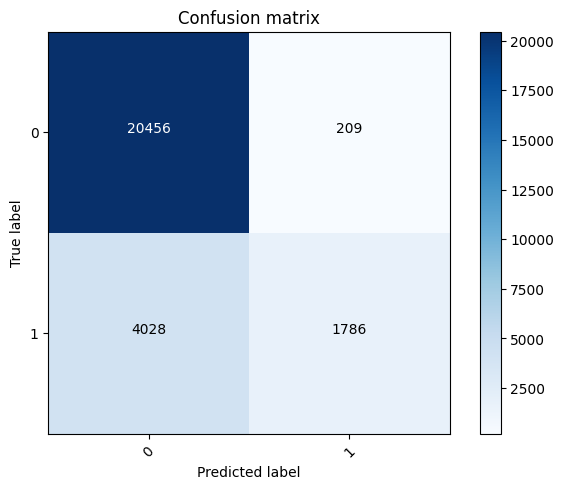

In [36]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 
# Confusion Matrix 

In [ ]:
# a shit way to show return

predicted_trues = X_test[y_pred]
prices = df_by_ticker.loc[predicted_trues.index]['future_prices']
percentage_returns = prices.apply(lambda df: df.iloc[0]['Close'] / df.iloc[0]['Open'])


x = percentage_returns-1
print(x.sum()*100, '% return')
print()

10415.690291723815 % return



In [ ]:
with open('saved_vars/random_forest/V1_randforest_acc0.864_return600%an.pkl', 'wb') as f:
    pickle.dump(clf, f)

## XGBoost